


























<a href="https://colab.research.google.com/github/hoangtc125/algo-clustering-service/blob/main/text_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NLP preparing

In [1]:
import gensim
import torch
import underthesea
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from transformers import AutoModel, AutoTokenizer, T5ForConditionalGeneration, T5Tokenizer

/home/hoangtc125/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
if torch.cuda.is_available():       
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

# Load model vector hóa
phobert = AutoModel.from_pretrained("vinai/phobert-base").to(device)
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")

# # Load model summarization
# model = T5ForConditionalGeneration.from_pretrained("NlpHUST/t5-small-vi-summarization")
# t5tokenizer = T5Tokenizer.from_pretrained("NlpHUST/t5-small-vi-summarization")
# model.to(device)

No GPU available, using the CPU instead.


Some weights of the model checkpoint at vinai/phobert-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [3]:
fname = 'vn_stopword.txt'
stopWordData = np.genfromtxt(fname, dtype='str', delimiter='\n', encoding="utf8")
stopWordData = stopWordData.tolist()

In [4]:
# Tạo các data theo nhóm cùng độ tương đồng để so sánh khoảng cách euclid sau khi vertor hóa
data = {
    "edu": [
      "Giáo dục là chìa khóa mở ra cánh cửa thành công trong cuộc đời.",
      "Giáo dục không chỉ giúp chúng ta có kiến thức mà còn rèn luyện tư duy logic.",
      "Giáo dục là nền tảng của một xã hội phát triển và thịnh vượng.",
      "Học hành không chỉ diễn ra trong trường học mà còn xảy ra trong cuộc sống hàng ngày.",
      "Một người học tập suốt đời sẽ không bao giờ cảm thấy mệt mỏi hay nhàm chán.",
      "Giáo dục là một cuộc chiến không bao giờ kết thúc giữa trí tuệ và sự ngu dốt.",
      "Học tập không chỉ để đạt được một bằng cấp mà còn để rèn luyện nhân cách.",
      "Giáo dục là con đường dẫn đến sự tự do và độc lập của con người.",
      "Trong giáo dục, sự tò mò và khám phá luôn là những động lực quan trọng.",
      "Giáo dục là sự đầu tư vào tương lai của chúng ta và xã hội.",
      "Giáo dục là chìa khóa mở ra cánh cửa tri thức",
      "Giáo dục là nền tảng cho sự phát triển bền vững của đất nước",
      "Giáo dục không chỉ là học vấn mà còn là cách sống",
      "Giáo dục giúp con người thấu hiểu thế giới xung quanh",
      "Giáo dục không giới hạn độ tuổi và không giới hạn thời gian",
      "Giáo dục cần phải được cập nhật và đổi mới liên tục",
      "Giáo dục không chỉ là truyền đạt kiến thức mà còn là truyền đạt giá trị",
      "Giáo dục đóng vai trò quan trọng trong việc hình thành nhân cách",
      "Giáo dục cần đào tạo ra nguồn nhân lực chất lượng cao",
      "Giáo dục là một quá trình không ngừng nghỉ trong cuộc đời",
  ],
  "health": [
      "Sức khỏe là tài sản quý giá nhất của con người.",
      "Có một tâm hồn khỏe mạnh là nền tảng của một cơ thể khỏe mạnh.",
      "Chăm sóc sức khỏe thường xuyên giúp ta tránh được nhiều căn bệnh nguy hiểm.",
      "Điều quan trọng nhất trong việc duy trì sức khỏe là thói quen ăn uống và sinh hoạt lành mạnh.",
      "Sức khỏe tốt giúp ta có thể đạt được mục tiêu trong cuộc sống.",
      "Chỉ cần một thói quen tốt, ta có thể cải thiện sức khỏe của mình rất nhiều.",
      "Để có một cơ thể khỏe mạnh, chúng ta cần vừa ăn uống đủ chất dinh dưỡng vừa tập thể dục thường xuyên.",
      "Sức khỏe không phải là điều kiện để sống, mà là cách để sống tốt hơn.",
      "Hạnh phúc và sức khỏe luôn đi đôi với nhau.",
      "Việc giữ gìn sức khỏe là trách nhiệm của chính chúng ta.",
      "Sức khỏe là tài sản quý giá nhất của con người.",
      "Hãy ăn uống đủ chất dinh dưỡng để duy trì sức khỏe tốt.",
      "Tập thể dục thường xuyên giúp cơ thể khỏe mạnh và tinh thần sảng khoái.",
      "Làm việc quá sức gây ảnh hưởng đến sức khỏe, hãy phân bổ thời gian hợp lý cho công việc và nghỉ ngơi.",
      "Ngủ đủ 7-8 tiếng mỗi ngày giúp cơ thể phục hồi và tái tạo năng lượng.",
      "Hút thuốc là nguyên nhân chính gây bệnh ung thư phổi và các bệnh lý khác, hãy từ bỏ thói quen này.",
      "Kiểm tra sức khỏe định kỳ giúp phát hiện sớm các bệnh lý và điều trị kịp thời.",
      "Hạn chế ăn đồ chiên, rán, nướng để giảm thiểu tác hại của chất béo động đến sức khỏe.",
      "Tránh uống rượu bia quá nhiều, vì nó gây hại đến gan và tác động đến sức khỏe tổng thể.",
      "Các bệnh lý tiểu đường, cao huyết áp, tim mạch đều có liên quan đến chế độ ăn uống và lối sống, hãy chú ý đến chúng.",
  ],
  "polution" :[
      "Ở đô thị, ô nhiễm môi trường là vấn đề cấp bách, người dân cần có những hành động cụ thể để bảo vệ sức khỏe của mình.",
      "Việc phát triển kinh tế đang đẩy mạnh các hoạt động công nghiệp, gây ra ô nhiễm môi trường nghiêm trọng và cần được khắc phục.",
      "Hạ tầng kém phát triển, công nghệ sản xuất lạc hậu và nhân thức chưa được nâng cao là những nguyên nhân gây ra ô nhiễm môi trường.",
      "Sự phát triển của các đô thị hiện nay đang gặp phải nhiều vấn đề về ô nhiễm môi trường, cần có giải pháp ngay để giảm thiểu tác động xấu đến cuộc sống con người.",
      "Các nguồn ô nhiễm môi trường như khói bụi, chất thải, hóa chất và các loại khí độc gây nguy hại đến sức khỏe con người.",
      "Tình trạng ô nhiễm môi trường đang ngày càng trầm trọng, gây ảnh hưởng không những đến sức khỏe con người mà còn đến sinh thái hệ địa phương và toàn cầu.",
      "Những nguyên nhân chính gây ra ô nhiễm môi trường là do hoạt động sản xuất, giao thông vận tải, xây dựng, đô thị hóa và sinh hoạt cá nhân.",
      "Việc sử dụng các nguồn năng lượng thay thế như năng lượng mặt trời, gió và nước là giải pháp hiệu quả để giảm thiểu ô nhiễm môi trường.",
      "Các quy định và chính sách về bảo vệ môi trường cần được áp dụng chặt chẽ và đầy đủ để giảm thiểu ô nhiễm môi trường.",
      "Hành động của mỗi cá nhân đều đóng góp vào việc giảm thiểu ô nhiễm môi trường, hãy cùng nhau chung tay bảo vệ môi trường xanh, sạch và đẹp.",
      "Ô nhiễm không khí gây hại cho sức khỏe của con người.",
      "Sông nước đang bị ô nhiễm nặng nề do công nghiệp và gia đình.",
      "Chất thải nhựa gây nên ô nhiễm môi trường lớn.",
      "Nạn ô nhiễm môi trường đang là mối đe dọa cho sinh thái và đời sống của con người.",
      "Việc tái chế là giải pháp hữu hiệu để giảm thiểu ô nhiễm môi trường.",
      "Thủy sản bị ô nhiễm gây hại cho sức khỏe người tiêu dùng.",
      "Việc phát thải khí thải gây ô nhiễm không khí đã trở thành một vấn đề lớn.",
      "Các loại chất độc hại trong nước thải có thể ảnh hưởng đến sức khỏe con người.",
      "Ô nhiễm môi trường là một vấn đề cần phải được xử lý nghiêm túc.",
      "Việc sử dụng năng lượng tái tạo là một giải pháp cho vấn đề ô nhiễm môi trường.",

  ],
  "startup": [
      "Khởi nghiệp là con đường để thực hiện đam mê và đạt được thành công lớn.",
      "Để khởi nghiệp thành công, ta cần có sự kiên trì, sáng tạo và tinh thần tự lập.",
      "Khởi nghiệp không đơn thuần là kinh doanh mà còn là một cuộc phiêu lưu tìm kiếm cơ hội và thử thách bản thân.",
      "Khởi nghiệp là cách để chúng ta tạo ra giá trị và có ảnh hưởng đến cộng đồng.",
      "Để thành công trong khởi nghiệp, ta cần có sự tỉ mỉ và kiên nhẫn trong từng bước đi.",
      "Khởi nghiệp không phải là con đường dễ dàng, nhưng nó đem lại cho ta sự tự do và độc lập trong công việc.",
      "Khởi nghiệp không chỉ là vấn đề tài chính mà còn cần sự quyết tâm và niềm đam mê không ngừng.",
      "Khởi nghiệp là con đường để chúng ta thể hiện tài năng và khả năng sáng tạo của mình.",
      "Thành công của một khởi nghiệp phụ thuộc vào khả năng tạo ra giá trị cho khách hàng.",
      "Sáng tạo và khả năng đổi mới là chìa khóa để thành công trong lĩnh vực khởi nghiệp.",
      "Khởi nghiệp không chỉ là việc bán sản phẩm hay dịch vụ, mà còn là việc giải quyết các vấn đề của xã hội.",
      "Thách thức lớn nhất của một khởi nghiệp là kiên trì vượt qua giai đoạn khởi đầu khó khăn.",
      "Một khởi nghiệp cần phải có ý tưởng sáng tạo và đội ngũ nhân viên đầy nhiệt huyết.",
      "Khởi nghiệp là con đường để tạo ra giá trị cho cộng đồng và xã hội.",
      "Việc đầu tư vào khởi nghiệp không chỉ là cách để kiếm lời, mà còn là sự đóng góp vào sự phát triển của xã hội.",
      "Một trong những yếu tố quan trọng của một khởi nghiệp thành công là khả năng thích ứng với thị trường.",
      "Tinh thần sáng tạo và kiên trì là chìa khóa để thành công trong việc khởi nghiệp.",
      "Một khởi nghiệp cần phải có một mô hình kinh doanh ổn định và đội ngũ quản lý chuyên nghiệp để phát triển và phát triển trong tương lai.",
      "Khởi nghiệp không chỉ đòi hỏi tư duy sáng tạo mà còn đòi hỏi kỹ năng quản lý và lãnh đạo.",
      "Thành công của một khởi nghiệp phụ thuộc vào việc giải quyết được vấn đề của khách hàng.",
  ],         
  "clothes": [
      "Áo sơ mi là một trong những item không thể thiếu trong tủ quần áo của bất kỳ chàng trai nào.",
      "Thiết kế của chiếc áo khoác này rất đặc biệt với những chi tiết đan xen giữa phong cách truyền thống và hiện đại.",
      "Trong những năm gần đây, thời trang unisex đang trở thành trào lưu hot trong giới trẻ.",
      "Bộ đồ thể thao không chỉ mang lại cảm giác thoải mái, dễ chịu khi tập luyện mà còn giúp bạn tự tin hơn trên phố.",
      "Đôi giày sneakers này không chỉ rất tiện dụng khi di chuyển mà còn có thiết kế phù hợp với nhiều hoàn cảnh khác nhau.",
      "Điểm nhấn của chiếc áo len này là màu sắc tươi sáng và họa tiết hoa văn độc đáo.",
      "Trang phục bó sát không chỉ giúp bạn khoe được những đường cong quyến rũ mà còn giúp bạn tự tin hơn trong mắt người đối diện.",
      "Túi xách là một trong những phụ kiện không thể thiếu cho phái đẹp. Chiếc túi này được làm từ chất liệu da cao cấp, tạo cảm giác sang trọng, đẳng cấp.",
      "Chất liệu denim của chiếc quần này rất đẹp và bền, tuy nhiên bạn cũng nên lưu ý về cách giặt và bảo quản để sản phẩm được bền lâu.",
      "Phong cách streetwear với chiếc hoodie này mang đến vẻ ngoài trẻ trung, cá tính cho bạn khi xuống phố.",
      "Mặc đẹp là phải có phong cách riêng.",
      "Có nhiều cách mix đồ để tạo nên phong cách thời trang.",
      "Hãy tìm cho mình một bộ trang phục vừa ấm áp vừa thoải mái để đón đầu mùa đông.",
      "Áo khoác denim là một trong những item không thể thiếu trong tủ đồ của mỗi người.",
      "Chọn đồ đúng cách sẽ giúp bạn tự tin hơn trong cuộc sống.",
      "Thời trang không chỉ là về quần áo, mà còn về phong cách sống.",
      "Không cần quá đắt tiền, chỉ cần biết cách mix đồ là bạn sẽ luôn thật sự lịch lãm.",
      "Cùng với thời trang, phụ kiện là một phần không thể thiếu trong bộ sưu tập của bạn.",
      "Hãy đầu tư cho những item quan trọng và phù hợp với phong cách của bạn.",
      "Nếu không biết mặc gì, hãy chọn những item cơ bản và dễ phối đồ như áo trắng, quần jean.",
  ],
  "history": [
      "Năm 1947, Kế hoạch Marshall được đưa ra để hỗ trợ châu Âu phục hồi sau Thế chiến thứ hai.",
      "Năm 1776, Tuyên ngôn độc lập Hoa Kỳ được ký kết.",
      "Năm 1991, Liên Xô tan rã và kết thúc Chiến tranh Lạnh.",
      "Năm 1688, Cách mạng dân chủ Anh diễn ra, đưa quyền lực của vua vào giới hạn.",
      "Năm 1865, Nô lệ bị giải phóng tại Hoa Kỳ sau Thế chiến thứ nhất.",
      "Công cuộc giải phóng dân tộc Việt Nam vào năm 1975 đã đánh dấu một trang sử mới trong lịch sử đất nước.",
      "Cuộc kháng chiến chống Mỹ của nhân dân Việt Nam đã góp phần lớn vào thắng lợi của cuộc chiến tranh giành độc lập và thống nhất đất nước.",
      "Thế kỷ 19 là thời kỳ phát triển của chủ nghĩa thực dân và bùng nổ của phong trào cách mạng dân tộc.",
      "Cuộc cách mạng tháng Mười Nga năm 1917 đã đánh dấu một sự kiện lớn của thế giới và là động lực cho các phong trào cách mạng khác trên thế giới.",
      "Công nguyên là một thời kỳ rất quan trọng trong lịch sử Trung Quốc.",
      "Triều đại Trần là một triều đại lịch sử quan trọng của Việt Nam.",
      "Chiến tranh thế giới thứ hai là cuộc chiến lớn nhất trong lịch sử loài người.",
      "Năm 1968 là một năm đầy biến động trong lịch sử thế giới.",
      "Cách mạng công nghiệp đã thay đổi hoàn toàn nền kinh tế thế giới.",
      "Năm 1789, Cách mạng Pháp đã đánh dấu sự khởi đầu của thời kỳ mới trong lịch sử châu Âu.",
      "Tôn Trung Sơn là một trong những vị tướng xuất sắc nhất trong lịch sử Trung Quốc.",
      "Năm 1954, Điện Biên Phủ đã chứng minh sức mạnh của quân dân Việt Nam và đánh dấu một bước ngoặt quan trọng trong lịch sử Việt Nam.",
      "Năm 1917, Cách mạng tháng Mười Nga đã đánh dấu sự khởi đầu của sự lên ngôi của chủ nghĩa xã hội trong lịch sử nhân loại.",
      "Năm 1865, Thống nhất nước Mỹ đã đánh dấu sự kết thúc của cuộc nội chiến và sự thống nhất của đất nước.",
      "Sự kiện Khiêu chiến tranh bị đánh bại vào năm 1894 đã đánh dấu sự suy yếu của chế độ phong kiến trước cuộc tấn công của các thế lực thực dân phương Tây.",
  ],    
}

In [5]:
features_dict = {}
features_set = []
for category, content in data.items():
  for id, line in enumerate(content):
    # Tiền xử lý dữ liệu
    line = gensim.utils.simple_preprocess(line)
    line = ' '.join(line)
    line = underthesea.word_tokenize(line, format="text") # Segment word
    line = ' '.join([word for word in line.split() if word not in stopWordData])
    # print(f"{category}-{id}", line)
    # if len(line.split()) > 100: # Summary long text
    # model.eval()
    #   print("summarizing...")
    #   tokenized_text = t5tokenizer.encode(line, return_tensors="pt").to(device)
    #   summary_ids = model.generate(
    #                       tokenized_text,
    #                       max_length=256, 
    #                       num_beams=5,
    #                       repetition_penalty=2.5, 
    #                       length_penalty=1.0, 
    #                       early_stopping=True
    #                   )
    #   line = t5tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    line = tokenizer(line, truncation=True).input_ids
    input_ids = torch.tensor([line]).to(torch.long)
    with torch.no_grad(): # Lấy features dầu ra từ BERT
        features = phobert(input_ids)
    v_features = features[0][:, 0, :].numpy()
    tuning_v_features = np.array([i for i in v_features[0]])
    features_dict[f"{category}-{id}"] = tuning_v_features
    features_set.append(tuning_v_features)
features_set = np.array(features_set)
features_set.shape, type(features_set), type(features_set[0])

((120, 768), numpy.ndarray, numpy.ndarray)

In [6]:
np.savetxt('features.txt', features_set)

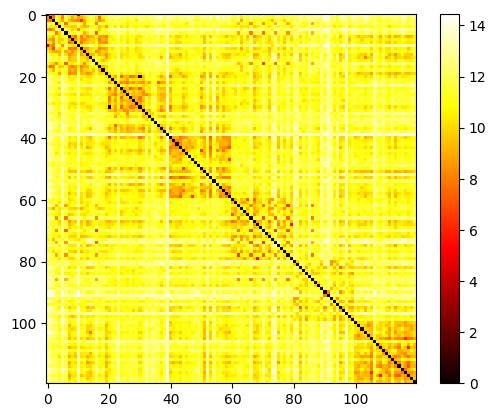

edu: 90.0%
health: 90.0%
polution: 100.0%
startup: 100.0%
clothes: 95.0%
history: 95.0%


,nearest,edu-0,edu-1,edu-2,edu-3,edu-4,edu-5,edu-6,edu-7,edu-8,...,history-10,history-11,history-12,history-13,history-14,history-15,history-16,history-17,history-18,history-19
edu-0,edu-10,0.00,8.43,7.69,12.30,11.68,8.55,12.68,10.52,9.78,...,12.80,12.75,12.96,13.01,12.49,13.37,13.05,12.27,12.84,12.78
edu-1,edu-17,8.43,0.00,7.77,11.73,10.41,8.00,11.58,10.46,8.90,...,12.38,12.16,12.52,12.64,12.16,13.40,12.98,11.98,12.69,12.66
edu-2,edu-11,7.69,7.77,0.00,11.53,10.42,8.84,11.54,9.35,8.55,...,11.44,11.72,11.91,12.35,11.80,12.68,12.66,11.31,12.19,11.97
edu-3,edu-6,12.30,11.73,11.53,0.00,10.17,12.49,7.82,11.13,11.27,...,11.65,11.27,12.33,12.05,11.70,12.43,11.95,11.89,12.48,11.98
edu-4,edu-19,11.68,10.41,10.42,10.17,0.00,11.38,9.87,9.85,9.67,...,11.17,10.13,10.90,10.88,11.26,11.94,11.40,10.92,11.15,11.76
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
history-15,history-16,13.37,13.40,12.68,12.43,11.94,13.66,12.92,10.67,11.45,...,8.73,9.55,11.18,9.77,9.43,0.00,7.63,9.35,9.78,10.60
history-16,history-5,13.05,12.98,12.66,11.95,11.40,13.21,12.20,9.75,10.82,...,8.14,8.53,10.74,8.43,8.56,7.63,0.00,8.41,8.45,8.99
history-17,history-8,12.27,11.98,11.31,11.89,10.92,12.35,11.79,8.92,10.24,...,9.78,7.82,10.13,7.51,7.18,9.35,8.41,0.00,8.92,9.44
history-18,history-5,12.84,12.69,12.19,12.48,11.15,12.71,11.78,9.41,10.59,...,9.80,9.22,10.70,8.97,9.17,9.78,8.45,8.92,0.00,9.61


In [7]:
def find_nearest_sample(v_features_dict):
  distances = []
  accuracy = {_k: 0 for _k in data}

  for key in v_features_dict:
    distance_i = {_k: np.linalg.norm(v_features_dict[key] - v_features_dict[_k]) for _k in v_features_dict}
    nearest_distance = list({k: v for k, v in sorted(distance_i.items(), key=lambda item: item[1])})[1]
    distance_i = {_k: round(_v, 2) for _k, _v in distance_i.items()}
    distances.append([nearest_distance, *distance_i.values()])
    category = str(key).split("-")[0]
    if category in nearest_distance:
      accuracy[category] = accuracy[category] + 1

  plt.imshow(np.array([ele[1:] for ele in distances]), cmap='hot', interpolation='nearest')
  plt.colorbar()
  plt.show()

  for key, value in accuracy.items():
    print(f"{key}: {round(100* value / len(data[key]), 2)}%")
    
    
  df = pd.DataFrame(distances, columns =["nearest", *v_features_dict.keys()], index=v_features_dict.keys())
  return df

find_nearest_sample(features_dict)

# sSMC-FCM Clustering

In [8]:
import sys
import math
import traceback
import scipy.optimize
import numpy as np
import matplotlib.pyplot as plt
from typing import Optional, List, Dict
from sklearn.metrics import hamming_loss

In [9]:
from enum import Enum

class FieldType(Enum):
    TEXT = "text"
    NUM = "num"
    CATE = "cate"

class sSMC_FCM():

  def __init__(
    self,
    dataset: List = [],
    fields_type: List = [],
    supervised_set: Optional[List] = [],
    n_clusters: Optional[int] = 3,
    fuzzi_M: Optional[int] = 2,
    alpha: Optional[float] = 0.6,
    epsilon: Optional[float] = 0.001,
    n_loop: Optional[int] = 50,
    is_plot: Optional[bool] = True
  ) -> None:
    self.dataset = dataset
    self.fields_type = fields_type if fields_type else [FieldType.TEXT] * len(dataset[0])
    self.n_clusters = max([n_clusters, len(supervised_set)]) 
    self.supervised_set = supervised_set
    self.fuzzi_M = fuzzi_M
    self.alpha = alpha
    self.epsilon = epsilon
    self.membership = [[0] * self.n_clusters for i in range(len(dataset))]
    self.fuzzi_set = [[fuzzi_M] * self.n_clusters for i in range(len(dataset))]
    self.centroid = []
    self.n_loop = n_loop
    self.is_stop = False
    self.pred_labels = [[] for _ in range(self.n_clusters)]
    self.is_plot = is_plot
    self.loss_values = []
    
  def clustering(self):
    self.__generate_centroid()
    th_loop = 1
    while th_loop <= self.n_loop and not self.is_stop:
      self.is_stop = True
      self.__update_membership(th_loop)
      self.__update_centroid(th_loop)
      self.__calculate_loss_function()
      th_loop += 1
    for idx, membership in enumerate(self.membership):
      id_cluster = np.argmax(membership)
      self.pred_labels[id_cluster].append(idx)
    self.pred_labels = np.array(self.pred_labels, dtype=object)
    # for idx, member in enumerate(self.membership):
    #   print(idx, member, np.argmax(member))

  def __generate_centroid(self):
    # computing centroid for supervised clusters
    for supervised_in_cluster in self.supervised_set:
      __centroid = []
      if not supervised_in_cluster:
        continue
      supervised_data = [self.dataset[i] for i in supervised_in_cluster]
      __centroid = np.sum(supervised_data, axis=0) / len(supervised_in_cluster)
      self.centroid.append(__centroid)

    #computing random centroid for unsupervised clusters (apply kmean++)
    for k in range(self.n_clusters - len(self.centroid)):
      ## initialize a list to store distances of data 
      ## points from nearest centroid 
      dist = [] 
      for i in range(self.dataset.shape[0]): 
        point = self.dataset[i, :] 
        d = sys.maxsize 
          
        ## compute distance of 'point' from each of the previously 
        ## selected centroid and store the minimum distance 
        for j in range(len(self.centroid)): 
          temp_dist = self.__calculate_point_distance(point, self.centroid[j]) 
          d = min(d, temp_dist) 
        dist.append(d) 
            
      ## select data point with maximum distance as our next centroid 
      dist = np.array(dist) 
      next_centroid = self.dataset[np.argmax(dist), :] 
      self.centroid.append(next_centroid) 
    
    self.centroid = np.array(self.centroid)
    self.plot("Initial Centroids") 

  def __update_membership(self, th_loop):

    # for idx, member in enumerate(self.membership):
    #   print(idx, member, np.argmax(member))

    fuzzi_M_pow = 1 / (self.fuzzi_M - 1)
    Dij = [
        [
            self.__calculate_point_distance(point, centroid)
            for centroid in self.centroid
        ]
        for point in self.dataset
    ]

    # without supervision
    for id_point, point in enumerate(self.dataset):
      Dij_pow = []
      sum_Dij_pow = 0
      for id_centroid, centroid in enumerate(self.centroid):
        Dik_pow = math.pow(Dij[id_point][id_centroid], fuzzi_M_pow)
        Dij_pow.append(Dik_pow)
        sum_Dij_pow += 1 / Dik_pow
      
      membership = [
          1 / (Dik_pow * sum_Dij_pow)
          for Dik_pow in Dij_pow
      ]
      self.membership[id_point] = membership
    
    # with supervision
    if th_loop == 2:
      self.__calculate_M2()
    for id_cluster, supervised_cluster in enumerate(self.supervised_set):
      for id_point in supervised_cluster:
        fuzzi_M2 = self.fuzzi_set[id_point][id_cluster]
        dmin = min(Dij[id_point])
        dij = [distance_ij / dmin for distance_ij in Dij[id_point]]
        uij = [
            math.pow(1 / (self.fuzzi_M * pow(dij[k], 2)), fuzzi_M_pow)
            if k != id_cluster else 0
            for k in range(self.n_clusters)
        ]
        right_expression = math.pow(1 / (fuzzi_M2 * pow(dij[id_cluster], 2)), 1 / (fuzzi_M2 - 1))
        uik_pow = (fuzzi_M2 - self.fuzzi_M) / (fuzzi_M2 - 1)
        def __func(uik):
            res = uik / ((uik + sum(uij)) ** uik_pow) - right_expression
            return res
        try:
            uik = scipy.optimize.fsolve(__func, 0)
            uik = uik[0]
            if not isinstance(uik, float):
                raise Exception("uik is complex")
            uij[id_cluster] = uik
        except:
            traceback.print_exc()
            continue
        membership = [uik / sum(uij) for uik in uij]
        self.membership[id_point] = membership

  def __update_centroid(self, th_loop):
    th_centroid = []
    for id_centroid, centroid in enumerate(self.centroid):
      uik_pow = [
          math.pow(self.membership[id_point][id_centroid], self.fuzzi_set[id_point][id_centroid])
          for id_point in range(len(self.dataset))
      ]
      new_centroid = np.sum([uik * point for uik, point in zip(uik_pow, self.dataset)], axis=0) / sum(uik_pow)
      th_centroid.append(new_centroid)
      if self.__calculate_point_distance(centroid, new_centroid) > self.epsilon:
        self.is_stop = False  
    self.centroid = np.array(th_centroid)
    self.plot(f"{th_loop}-th loop")
    
  def plot(self, title: Optional[str] = None): 
      if not self.is_plot:
        return
      color = iter(plt.cm.rainbow(np.linspace(0, 1, self.n_clusters)))
      for idx, cluster in enumerate(self.supervised_set):
        c = next(color)
        supervised_points = np.array([self.dataset[id].tolist() for id in cluster])
        plt.scatter(supervised_points[:, 0], supervised_points[:, 1], marker = 'x',
                    color = c, label = f'supervised points {idx}')

      color = iter(plt.cm.rainbow(np.linspace(0, 1, self.n_clusters)))
      cluster_members = [[] for _ in range(self.n_clusters)]
      for point, membership in zip(self.dataset, self.membership):
        id_cluster = np.argmax(membership)
        cluster_members[id_cluster].append(point.tolist())
      for cluster_member in cluster_members:
        if not cluster_member:
          continue
        cluster_member = np.array(cluster_member)
        c = next(color)
        plt.scatter(cluster_member[:, 0], cluster_member[:, 1], marker = '.',  
                    color = c, label = 'cluster points') 
      plt.scatter(self.centroid[:, 0], self.centroid[:, 1],  
                  color = 'black', label = 'cluster centroids') 
      plt.title(title) 
      plt.legend(bbox_to_anchor =(1, 1))
      plt.xlim(min(self.dataset[:, 0]), max(self.dataset[:, 0])) 
      plt.ylim(min(self.dataset[:, 1]), max(self.dataset[:, 1])) 
      plt.show() 

  def __calculate_M2(self):
    for id_cluster, supervised_cluster in enumerate(self.supervised_set):
      for id_point in supervised_cluster:
        if self.membership[id_point][id_cluster] >= self.alpha:
          continue
        right_expression = self.fuzzi_M * math.pow((
                              (1 - self.alpha) / (1 / self.membership[id_point][id_cluster] - 1)
                            ), self.fuzzi_M - 1)
        def __func(fuzzi_M2):
            res = fuzzi_M2 * math.pow(self.alpha, fuzzi_M2 - 1) - right_expression
            return res
        try:
            fuzzi_M2 = scipy.optimize.fsolve(__func, self.fuzzi_M)
            fuzzi_M2 = fuzzi_M2[0]
            if not isinstance(fuzzi_M2, float):
                raise Exception("fuzzi_M2 is complex")
            self.fuzzi_set[id_point][id_cluster] = fuzzi_M2 if fuzzi_M2 > self.fuzzi_M else self.fuzzi_M
            # print(id_point, self.fuzzi_set[id_point][id_cluster])
        except:
            traceback.print_exc()

  def __calculate_point_distance(self, p1, p2):
    distance = 0
    for field1, field2, field_type in zip(p1, p2, self.fields_type):
      if field_type in [FieldType.TEXT, FieldType.NUM]:
        distance += self.__calculate_euclid_distance(field1, field2)
      elif field_type in [FieldType.CATE]:
        distance += self.__calculate_hamming_distance(field1, field2)
    return distance if distance else self.epsilon

  def __calculate_euclid_distance(self, p1, p2):
    return np.linalg.norm(p1 - p2)

  def __calculate_hamming_distance(self, p1, p2):
    return hamming_loss(p1, p2)
    
  def __calculate_loss_function(self):
    self.loss_values.append(sum([
        sum([
            math.pow(self.membership[id_point][id_centroid], self.fuzzi_set[id_point][id_centroid]) * self.__calculate_point_distance(point, centroid)
            for id_centroid, centroid in enumerate(self.centroid)
        ])
        for id_point, point in enumerate(self.dataset)
    ]))

  def show_cluster_members(self):
    len_supervised = sum([len(supervised_set) for supervised_set in self.supervised_set])
    len_dataset = len(self.dataset)
    print(f"Supervised percentage: {round(100 * len_supervised / len_dataset, 2)}% ({len_supervised}:{len_dataset})")
    print("Cluster members: ")
    for cluster in self.pred_labels:
      print(cluster)

  def show_loss_function(self):
    plt.plot(self.loss_values)
    plt.title("Loss function") 
    plt.show()
    print("loss functions: ")
    print(self.loss_values)

In [10]:
new_features = []
for feature in features_set:
  new_features.append([feature])
new_features = np.array(new_features)

Supervised percentage: 18.33% (22:120)
Cluster members: 
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 49]
[40, 41, 42, 43, 44, 45, 46, 47, 48, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]
[60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
[80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
[100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119]


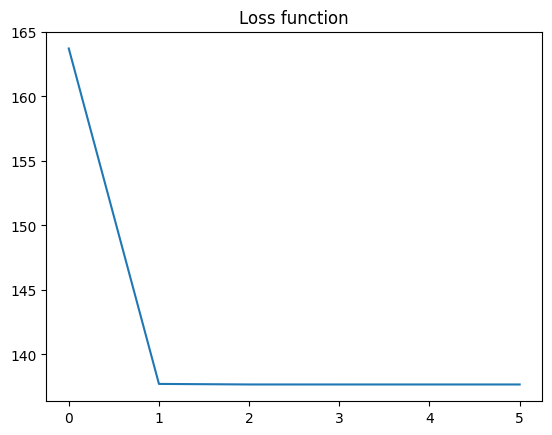

loss functions: 
[163.72206167969944, 137.71322917241844, 137.6711083551957, 137.67013319836377, 137.67010325018336, 137.67010213716034]


In [11]:
# supervised_set = [
#     [1, 3, 14, 19],
#     [20, 33, 34, 37, 39],
#     [40, 44, 52, 55],
#     [62, 65, 71, 75],
#     [80, 82, 83, 88],
#     [103, 106],
# ]
supervised_set = [
    [1, 3, 7, 14],
    [20, 25, 33, 39],
    [44, 51, 54, 57],
    [62, 65, 71, 77],
    [83, 88, 99],
    [103, 106, 116],
]
ssmc_fcm = sSMC_FCM(
    dataset=new_features, 
    fields_type=[FieldType.TEXT], 
    n_clusters=6, 
    supervised_set=supervised_set, 
    is_plot=False
)
ssmc_fcm.clustering()
ssmc_fcm.show_cluster_members()
ssmc_fcm.show_loss_function()

Supervised percentage: 14.0% (21:150)
Cluster members: 
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
[50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
[77, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149]


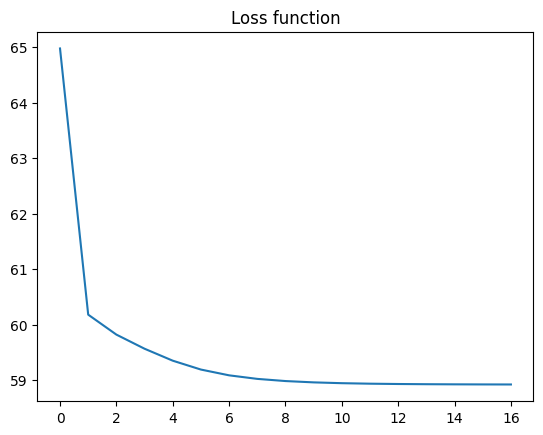

loss functions: 
[64.97378115985664, 60.17765544617555, 59.81810079906632, 59.563619296850824, 59.3482338957609, 59.1882098282132, 59.08429020204603, 59.02026199255627, 58.98121081489229, 58.957395108966935, 58.94277355653964, 58.93369724044584, 58.92799191351646, 58.92436190053248, 58.92202772822512, 58.92051369621643, 58.919524885156065]


In [12]:
from sklearn.datasets import load_iris
data = load_iris()
X, Y = np.array([[i] for i in data['data']]), data['target']

supervised_set = [
    [1, 11, 22], 
    [71, 81, 92, 86, 50, 52, 76, 77, 83], 
    [122, 123, 124, 126, 121, 106, 113, 138, 119], 
]
ssmc_fcm = sSMC_FCM(dataset=X, n_clusters=3, supervised_set=supervised_set, is_plot=False)
ssmc_fcm.clustering()
ssmc_fcm.show_cluster_members()
ssmc_fcm.show_loss_function()